# Extracting and Visualizing Image Regions From VIA JSON Annotations

A script for extracting head bounding boxes annotated using VIA and saved in a JSON file.

This script also allows us to visualize the annotated head bounding box for a particular image frame.

In [1]:
import json
import os

In [2]:
import cv2
import pickle

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 12] # matplotlib setting to control the size of display images

In [4]:
def extract_via_image_regions_from_json_file(via_filename):
    """
    Extracts bounding box image regions annotated by VIA from JSON file.
    
    Parameters:
    - via_filename: filename of a VIA project saved as a JSON file.
    
    Returns a dictionary where key is frame filename, and value is (x, y, w, h) tuple of the annotated head bounding box in the frame.
    """
    via = {}
    with open(via_filename, 'r') as f:
        via = json.load(f)

    # Create dictionary mapping keys of fid to filename
    fid_to_filename_map = {}
    for fid in via["file"]:
        fid_to_filename_map[fid] = via["file"][fid]["fname"]

    # Create dictionary mapping keys of fid to (x, y, w, h) tuple representing the coords of the head bounding box in that file
    fid_to_bounding_box_coords_map = {}
    for file in via["metadata"]:
        _, x, y, w, h = via["metadata"][file]["xy"]
        fid = via["metadata"][file]["vid"]
        fid_to_bounding_box_coords_map[fid] = (x, y, w, h)
    
    # Create dictionary mapping key of filename to (x, y, w, h) tuple of the annotated head bounding box in the frame.
    filename_to_bounding_box_coords_map = {}
    for fid in fid_to_filename_map:
        filename = fid_to_filename_map[fid]
        bounding_box_coords = fid_to_bounding_box_coords_map[fid]
        filename_to_bounding_box_coords_map[filename] = bounding_box_coords
    
    return filename_to_bounding_box_coords_map

In [5]:
def load_rgb_img(img_path):
    """
    Takes in img_path, the file path to an image.
    Reads the image at that path, and returns the RGB image.
    """
    img_raw = cv2.imread(img_path)
    
    # OpenCV imread reads in images in BGR color space, so must convert from BGR to RGB
    img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    
    return img_rgb

In [6]:
def visualize_annotated_head_bounding_box(frame_filename, via_filename_to_bounding_box_coords_map):
    """
    Uses matplotlib to display an image with annotated head bounding box drawn onto the image.
    
    Parameters:
    - frame_filename: the filename of the frame whose annotated bounding box we wish to visualize.
    - via_filename_to_bounding_box_coords_map: dictionary mapping key of filename to (x, y, w, h) tuple of the annotated head bounding box in the frame.
    """  
    # Find original image from frames folder
    frame_num_and_extension = frame_filename.split("_")[-1]
    clip_name = frame_filename.replace("_" + frame_num_and_extension, "")
    img = load_rgb_img("frames/" + clip_name + "_frames/" + frame_filename)
    
    # Make a copy of original image so original image is retained while we draw bounding boxes on the copy
    img_head_localization = img.copy()
    
    # Find the bounding box coords for this particular frame
    head_bounding_box_coords = via_filename_to_bounding_box_coords_map[frame_filename]
    x, y, w, h = head_bounding_box_coords
    
    # Convert from floats to ints because cv2.rectangle expects ints
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)

    # Draw the annotated head bounding box
    img_head_localization = cv2.rectangle(img_head_localization,(x,y),(x+w,y+h),(247,222,58),2)
    
    plt.imshow(img_head_localization)
    plt.show()

In [7]:
# Create frame filename to annotated head bounding box dictionary, from VIA JSON file
via_filename_to_bounding_box_coords_map = extract_via_image_regions_from_json_file("frame_to_head_annotations.json")

# Save (serialize) pickle of the VIA head bounding box dictionary
pickled_dict_filepath = "frame_to_head_box_annotation" + ".pkl"
with open(pickled_dict_filepath, "wb") as f:
    pickle.dump(via_filename_to_bounding_box_coords_map, f)

# Test loading (deserializing) pickled data to make sure pickled file saved correctly
with open(pickled_dict_filepath, "rb") as f:
    pass
    # print(pickle.load(f))

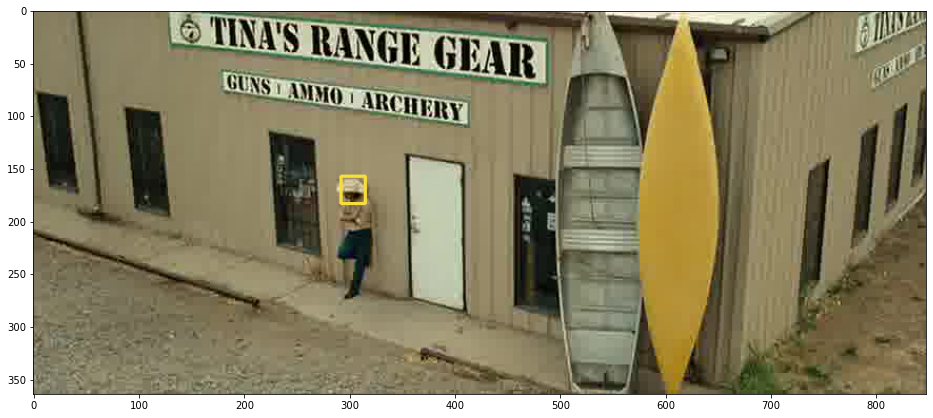

In [8]:
visualize_annotated_head_bounding_box("no_country_clip2_01345.jpg", via_filename_to_bounding_box_coords_map)